In [ ]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import glob
import sys
import re
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# tsfresh imports
from tsfresh.feature_extraction import extract_features
from tsfresh.feature_extraction.settings import MinimalFCParameters

In [ ]:
# Dask imports
!pip install dask[distributed]
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.7 MB/s eta 0:00:00


<section id="preSec"> </section>

<!DOCTYPE html>
<html>
<head>
</head>
<body>
    <h3 align="center"> Parquet Dataset Information </h3>
    <p>Series to be used as training data, partitioned by id. Each series is a continuous recording of accelerometer data for a single subject spanning many days.</p>
    <table>
      <tr>
        <th>Field Name</th>
        <th>Explanation</th>
      </tr>
      <tr>
        <td>id</td>
        <td>The patient identifier corresponding to the id field in train/test.csv.</td>
      </tr>
      <tr>
        <td>step</td>
        <td>An integer timestep for each observation within a series.</td>
      </tr>
      <tr>
        <td>X,Y,Z</td>
        <td>Measure of acceleration, in g, experienced by the wrist-worn watch along each standard axis.</td>
      </tr>
      <tr>
        <td>enmo</td>
        <td>As calculated and described by the wristpy package, ENMO is the Euclidean Norm Minus One of all accelerometer signals (along each of the x-, y-, and z-axis, measured in g-force) with negative values rounded to zero. Zero values are indicative of periods of no motion. While no standard measure of acceleration exists in this space, this is one of the several commonly computed features.</td>
      </tr>
      <tr>
        <td>anglez</td>
        <td>As calculated and described by the wristpy package, Angle-Z is a metric derived from individual accelerometer components and refers to the angle of the arm relative to the horizontal plane.</td>
      </tr>
      <tr>
        <td>non-wear_flag</td>
        <td>A flag (0: watch is being worn, 1: the watch is not worn) to help determine periods when the watch has been removed, based on the GGIR definition, which uses the standard deviation and range of the accelerometer data.</td>
      </tr>
      <tr>
        <td>light</td>
        <td>Measure of ambient light in lux. See ​​here for details.</td>
      </tr>
      <tr>
        <td>battey_voltage</td>
        <td>measure of the battery voltage in mV.</td>
      </tr>
      <tr>
        <td>time_of_day</td>
        <td>Time of day representing the start of a 5s window that the data has been sampled over, with format %H:%M:%S.%9f.</td>
      </tr>
      <tr>
        <td>weekday</td>
        <td>The day of the week, coded as an integer with 1 being Monday and 7 being Sunday.</td>
      </tr>
      <tr>
        <td>quater </td>
        <td>The quarter of the year, an integer from 1 to 4.</td>
      </tr>
      <tr>
        <td>relative_date_PCIAT</td>
        <td>The number of days (integer) since the PCIAT test was administered (negative days indicate that the actigraphy data has been collected before the test was administered).</td>
      </tr>
    </table>
    <br>
</body>
</html>

<h1>EDA - Exploratory Data Analysis</h1>
There are almost 1000 Time Series representing 1000 different kids, It is impossible to visualize every timeseries. So what I will do is analyze a random timeseries to understand the Behavior of the time series data. 

In [ ]:
# Plot 
actigraphy = pd.read_parquet('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0417c91e/part-0.parquet')
display(actigraphy.head(5),actigraphy.shape)
actigraphy.describe()

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0,0.014375,-0.020112,-0.995358,0.001060,-88.445251,0.0,41.000000,4195.000000,44100000000000,2,2,5.0
1,1,0.014167,-0.023278,-0.996164,0.000289,-88.372200,0.0,41.000000,4194.833496,44105000000000,2,2,5.0
2,2,0.014036,-0.022964,-0.996320,0.000301,-88.356422,0.0,41.500000,4194.666504,44110000000000,2,2,5.0
3,3,0.013593,-0.022048,-0.996762,0.002278,-88.575943,0.0,37.500000,4194.500000,44115000000000,2,2,5.0
4,4,-0.061772,-0.065317,-0.973063,0.092321,-88.391273,0.0,55.666668,4199.000000,44780000000000,2,2,5.0


(287179, 13)

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
count,287179.000000,287179.000000,287179.000000,287179.000000,287179.000000,287179.000000,287179.0,287179.000000,287179.000000,2.871790e+05,287179.000000,287179.000000,287179.000000
mean,143589.000000,-0.147090,-0.017002,-0.004732,0.058441,-0.796539,0.0,123.444946,3922.278076,4.805124e+13,3.957786,2.356349,19.735792
std,82901.580815,0.592653,0.523109,0.482261,0.111350,32.938553,0.0,366.268463,129.543121,1.778458e+13,1.950902,0.478921,9.147491
min,0.000000,-2.369030,-2.392287,-1.039420,0.000000,-89.850655,0.0,0.000000,3680.000000,0.000000e+00,1.000000,2.000000,5.000000
25%,71794.500000,-0.661335,-0.389971,-0.379056,0.012036,-23.917739,0.0,2.797670,3806.000000,3.504000e+13,2.000000,2.000000,12.000000
50%,143589.000000,-0.307503,-0.002656,0.005460,0.031590,0.035168,0.0,9.067637,3900.000000,4.810000e+13,4.000000,2.000000,19.000000
75%,215383.500000,0.385957,0.349525,0.334612,0.066772,19.996507,0.0,33.381310,4021.875000,6.201500e+13,6.000000,3.000000,28.000000
max,287178.000000,1.497262,2.430707,2.013542,4.000618,89.683189,0.0,2642.399902,4199.000000,8.639500e+13,7.000000,3.000000,53.000000


In [ ]:
def plot_series_data(df, col='non-wear_flag',
                     label='Worn (0 = Worn, 1 = Not Worn)',
                     title='Non-Wear Flag',
                     x_col='day_time', x_label='Day Relative to PCIAT + Time'):
    plt.figure(figsize=(18, 12))
    
    # ENMO
    plt.subplot(4, 1, 1)
    plt.scatter(df[x_col], df['enmo'], label='ENMO', color='green', s=1)
    plt.title('ENMO (Euclidean Norm Minus One)')
    plt.ylabel('Movement Intensity')

    # Angle Z
    plt.subplot(4, 1, 2)
    plt.scatter(df[x_col], df['anglez'], label='Angle Z', color='blue', s=1)
    plt.title('Angle Z')
    plt.ylabel('Angle (degrees)')

    # Light
    plt.subplot(4, 1, 3)
    plt.scatter(df[x_col], df['light'], label='Light', color='orange', s=1)
    plt.title('Ambient Light')
    plt.ylabel('Light (lux)')

    # Any other column
    plt.subplot(4, 1, 4)
    plt.scatter(df[x_col], df[col], label=col, color='red', s=1)
    plt.title(f'{title}')
    plt.ylabel(f'{label}')
    plt.xlabel(f'{x_label}')

    plt.tight_layout()
    plt.show()

<h3>Create time series index</h3>
Although I get plenty of time metrics I don't have yet a index column represting the time. Therefore, I made a continuous time scale in days by transforming the time_of_day column (which is in nanoseconds) to hours and then combining it with relative_date_PCIAT

In [ ]:
def create_time_index(series_train):
    series_train['time_of_day_hours'] = (
        series_train['time_of_day'] / 1e9 / 3600 #nanoseconds to hours
    )
    series_train['day_time'] = series_train['relative_date_PCIAT'] + (
        series_train['time_of_day_hours'] / 24
    )
create_time_index(actigraphy)
actigraphy['day_time']

0          5.510417
1          5.510475
2          5.510532
3          5.510590
4          5.518287
            ...    
287174    53.380498
287175    53.380556
287176    53.380613
287177    53.380671
287178    53.380729
Name: day_time, Length: 287179, dtype: float64

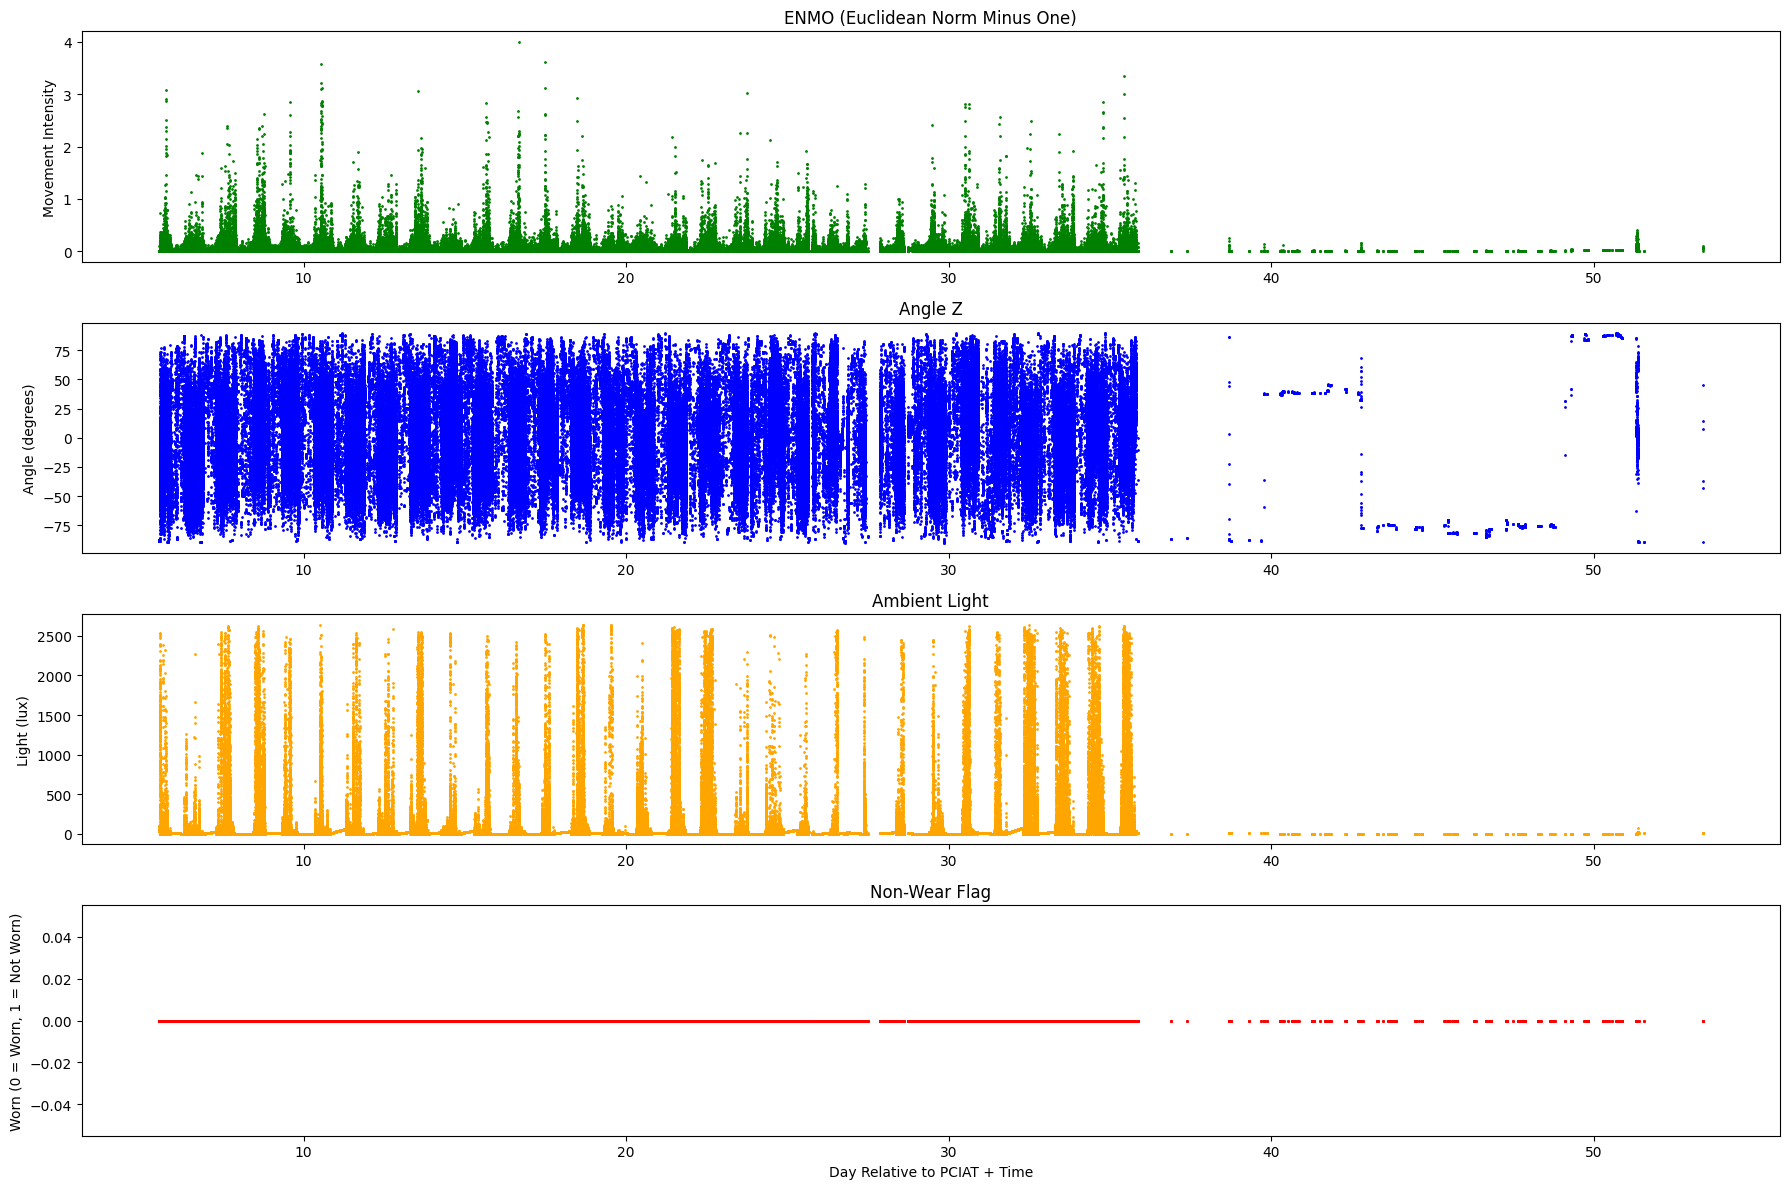

In [ ]:
plot_series_data(actigraphy, x_col='day_time', x_label='Day Relative to PCIAT + Time')

<h1>Automated Feature Extraction</h1>
For this automated feature extraction I have decided to use tsfresh & Dask
<li>Create a Dask Cluster and connect a Client to it.</li>
<li>Read data using Dask DataFrame</li>
<li>Extract features using using tsfresh. Use Dask to parallelizes execution with map_partitions</li>
<li>Write the final dataframe back</li>

<h3>1. Define Basic configuration</h3>

In [ ]:
# Path for raw data
DATA_DIR = "/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id="
DATA_TYPE = "/part-0.parquet"
# Path to save generated features
FEATURE_PATH = "/kaggle/input/child-mind-institute-problematic-internet-use"
path_to_files = glob.glob(os.path.join(DATA_DIR + "*", "part-0.parquet"))

# Define the datatypes for different sensor data
data_types = {"X" : np.float64, 
             "Y" : np.float64, 
             "Z" : np.float64,
             "enmo" : np.float64,
             "anglez" : np.float64,
             "non-wear_flag" : np.float64,
             "light" : np.float64,
             "battery_voltage" : np.float64,
             "time_of_day" : np.float64,
             "weekday" : np.float64,
             "quarter" : np.float64,
             "relative_date_PCIAT" : np.float64,
             'id': 'object'}

<h3>2. Create a Dask Cluster and connect a Client to it</h3>

In [ ]:
cluster = LocalCluster(n_workers=8, 
                       threads_per_worker=1, 
                       scheduler_port=8786, 
                       memory_limit='3GB')

client = Client(cluster)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 22.35 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:8786,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 22.35 GiB
Comm: tcp://127.0.0.1:40719,Total threads: 1
Dashboard: http://127.0.0.1:33729/status,Memory: 2.79 GiB
Nanny: tcp://127.0.0.1:34159,


<h3>3. Convert files to csv</h3>

In [ ]:
def extract_id_from_path(path):
    match = re.search(r'id=([a-zA-Z0-9]+)/', path)
    if match:
        return match.group(1)
    else:
        raise ValueError(f"Cannot extract ID from path: {path}")

In [ ]:
# Covert every 
for path in path_to_files:
    unique_id  = extract_id_from_path(path)
    df = pd.read_parquet(path, engine="pyarrow",columns=['X', 'Y', 'Z', 'enmo', 'anglez', 'non-wear_flag', 'light',
                 'battery_voltage', 'time_of_day', 'weekday', 'quarter',
                 'relative_date_PCIAT'])
    OUTPUT = '/kaggle/working/'
    CSV = '.csv'
    df.to_csv(OUTPUT + unique_id + CSV, index=False)

In [ ]:
# Path to save generated features
DATA_DIR_WORK = "/kaggle/working/"
DATA_TYPE_WORK = ".csv"

urlpath = glob.glob(os.path.join(DATA_DIR_WORK + "*"))

<h3>4. Read Data using Dask DataFrame</h3>

In [ ]:
# Create an new column called segment id that is comprised of the path variable
def get_segment_id_from_path(df, path):
    """
    Returns the segment_id from the path of the file 
    """
    df.segment_id = df.segment_id.str.replace(path, "", regex=False)
    df.segment_id = df.segment_id.str.replace(".csv", "", regex=False)
    
    return df

def append_time_column(df):
    df["time"] = range(0, len(df))
    
    return df

In [ ]:
ddf = dd.read_parquet(
    path_to_files, 
    blocksize=None, 
    columns=['X', 'Y', 'Z', 'enmo', 'anglez', 'non-wear_flag', 'light',
                 'battery_voltage', 'time_of_day', 'weekday', 'quarter',
                 'relative_date_PCIAT','id'])

# Add a column named time with ascending values staring from 0 representing time
ddf = ddf.map_partitions(append_time_column)

# Change columns types 
for col, dtype in data_types.items():
    ddf[col] = ddf[col].astype(dtype)

ddf['id'] = ddf['id'].fillna('a')

<h3>5. Generate Features for individual partitions in parallel using Dask</h3>

In [ ]:
def custom_extract_features(df, column_id, column_sort, default_fc_parameters):
    """
    Generate features using `extract_features` of `tsfresh` and then rename and 
    reset axis.
    
    Setting `n_jobs` to 0 disable multiprocessing functionality
    """
    feature_df = extract_features(df, 
                                  column_id=column_id, 
                                  column_sort=column_sort, 
                                  n_jobs=0, 
                                  default_fc_parameters=default_fc_parameters,
                                  disable_progressbar=True)
    feature_df = feature_df.rename_axis("id").reset_index(drop=False)
    feature_df.id = feature_df.id.astype('category')
    return feature_df

In [ ]:
ddf_features = ddf.map_partitions(custom_extract_features, 
                                  column_id='id',
                                  column_sort='time',
                                  default_fc_parameters=MinimalFCParameters())

In [ ]:
ddf_features.compute()

,id,X__sum_values,X__median,X__mean,X__length,X__standard_deviation,X__variance,X__root_mean_square,X__maximum,X__absolute_maximum,...,relative_date_PCIAT__sum_values,relative_date_PCIAT__median,relative_date_PCIAT__mean,relative_date_PCIAT__length,relative_date_PCIAT__standard_deviation,relative_date_PCIAT__variance,relative_date_PCIAT__root_mean_square,relative_date_PCIAT__maximum,relative_date_PCIAT__absolute_maximum,relative_date_PCIAT__minimum
0,0a418b57,41822.372157,0.304541,0.195960,213423.0,0.539904,0.291497,0.574367,1.648549,2.156349,...,238676.0,1.0,1.118324,213423.0,6.136560,37.657370,6.237629,25.0,25.0,-9.0
0,0a431608,43243.274134,0.222212,0.167186,258654.0,0.551335,0.303971,0.576127,2.407046,2.407046,...,4861067.0,19.0,18.793705,258654.0,6.824283,46.570837,19.994354,31.0,31.0,7.0
0,0b7d7aec,22081.483534,0.216043,0.054289,406740.0,0.395393,0.156335,0.399102,0.903042,0.980655,...,76041516.0,187.0,186.953621,406740.0,6.803258,46.284322,187.077366,199.0,199.0,175.0
0,0b7d9da6,-85227.244933,-0.473731,-0.348368,244647.0,0.500517,0.250517,0.609818,1.609037,1.946590,...,7510332.0,29.0,30.698647,244647.0,9.555372,91.305137,32.151393,60.0,60.0,17.0
0,0b50f3fa,13458.075020,0.059867,0.033353,403500.0,0.531012,0.281974,0.532059,2.468796,2.552884,...,6765804.0,17.0,16.767792,403500.0,6.745363,45.499923,18.073704,28.0,28.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,fe9c71d8,35705.746165,0.049404,0.083682,426684.0,0.566568,0.321000,0.572715,1.768048,1.768048,...,8695872.0,20.0,20.380122,426684.0,7.137220,50.939907,21.593732,33.0,33.0,8.0
0,fecc07d6,15423.270934,0.030246,0.037227,414300.0,0.088870,0.007898,0.096353,1.002917,1.008362,...,4946400.0,12.0,11.939175,414300.0,6.932951,48.065815,13.806147,24.0,24.0,0.0
0,ff18b749,13588.109305,0.075583,0.035303,384900.0,0.639187,0.408560,0.640161,1.441266,2.312154,...,-9205788.0,-24.0,-23.917350,384900.0,6.440848,41.484517,24.769420,-13.0,35.0,-35.0
0,ffcd4dbd,157153.384180,0.538555,0.377523,416275.0,0.523033,0.273563,0.645048,1.622884,1.852794,...,25086288.0,60.0,60.263739,416275.0,6.960969,48.455095,60.664432,72.0,72.0,48.0


<h3>6.Create final dataframe</h3>

In [ ]:
result_temp = ddf_features.compute()
result_temp.to_csv("final_form.csv",index=False)

In [ ]:
def analyze_actigraphy(id, only_one_week=False, small=False):
    actigraphy = pl.read_parquet(f'/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id={id}/part-0.parquet')
    day = actigraphy.get_column('relative_date_PCIAT') + actigraphy.get_column('time_of_day') / 86400e9
    sample = train.filter(pl.col('id') == id)
    age = sample.get_column('Basic_Demos-Age').item()
    sex = ['boy', 'girl'][sample.get_column('Basic_Demos-Sex').item()]
    actigraphy = (
        actigraphy
        .with_columns(
            (day.diff() * 86400).alias('diff_seconds'),
            (np.sqrt(np.square(pl.col('X')) + np.square(pl.col('Y')) + np.square(pl.col('Z'))).alias('norm'))
        )
    )

    if only_one_week:
        start = np.ceil(day.min())
        mask = (start <= day.to_numpy()) & (day.to_numpy() <= start + 7*3)
        mask &= ~ actigraphy.get_column('non-wear_flag').cast(bool).to_numpy()
    else:
        mask = np.full(len(day), True)
        
    if small:
        timelines = [
            ('enmo', 'forestgreen'),
            ('light', 'orange'),
        ]
    else:
        timelines = [
            ('X', 'm'),
            ('Y', 'm'),
            ('Z', 'm'),
#             ('norm', 'c'),
            ('enmo', 'forestgreen'),
            ('anglez', 'lightblue'),
            ('light', 'orange'),
            ('non-wear_flag', 'chocolate')
    #         ('diff_seconds', 'k'),
        ]
        
    _, axs = plt.subplots(len(timelines), 1, sharex=True, figsize=(12, len(timelines) * 1.1 + 0.5))
    for ax, (feature, color) in zip(axs, timelines):
        ax.set_facecolor('#eeeeee')
        ax.scatter(day.to_numpy()[mask],
                   actigraphy.get_column(feature).to_numpy()[mask],
                   color=color, label=feature, s=1)
        ax.legend(loc='upper left', facecolor='#eeeeee')
        if feature == 'diff_seconds':
            ax.set_ylim(-0.5, 20.5)
    axs[-1].set_xlabel('day')
    axs[-1].xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    axs[0].set_title(f'id={id}, {sex}, age={age}')
    plt.show()

analyze_actigraphy('0417c91e', only_one_week=False)

V1 - drop all the columns that represent the count elemnt in the describe function. Those column are reddundent
broght worse results than before

In [ ]:
def drop_columns(train_ts, test_ts):
    train_ts = train_ts.drop(train_ts.iloc[:,1:10].columns,axis=1)
    test_ts = test_ts.drop(test_ts.iloc[:,1:10].columns,axis=1)
    return train_ts, test_ts

V2 - Keep only highly correlated features to target inside the time series dataset

In [ ]:
id_and_target_train = pd.concat([Target_series, train_id], axis=1)

train_merged = id_and_target_train.merge(train_ts, on='id', how='left')
train_merged.drop('id',axis=1,inplace=True)
temp_corr = train_merged.corr()
#temp_corr["sii"].sort_values(ascending=False)

filtered_series = temp_corr["sii"][abs(temp_corr["sii"]) > 0.08]
row_names = filtered_series.index.tolist()
row_names.remove('sii')
train_ts[row_names]